#Прогин круглої пластинки.

$\cfrac{1}{r}\cfrac{d}{dr} \left( r\cfrac{d}{dr} \left( \cfrac{1}{r} \cfrac{d}{dr} \left( r \cfrac{dw}{dr} \right) \right) \right) = \cfrac{q}{D}$

Або

$\cfrac{d^4w}{dr^4}+\cfrac{2}{r}\cfrac{d^3w}{dr^3}-\cfrac{1}{r^2}\cfrac{d^2w}{dr^2}+\cfrac{1}{r^3}\cfrac{dw}{dr}=\cfrac{q}{D}$

##Кругла пластинка защемлена по контуру

Граничні умови:

$\cfrac{dw}{dr}(a)=0, $

$\cfrac{dw}{dr}(0)=0, $

$w(a)=0.$

Тоді розв'язок:

$w(r)=\cfrac{q}{64D}(a^2-r^2)^2$

Максимальний прогин в центрі пластини:

$w_{max}=\cfrac{qa^4}{64D}$

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
a = 0.4
q = 0.1
G = 2.77 * 10**4
nu = 0.3
E = 2*G*(1+nu)
h = 18*10**(-3)
D = E*h**3/(12*(1-nu**2))
print(E)
print(D)
print(q/D)

72020.0
0.03846342857142858
2.5998722348501726


In [ ]:
def w(r, D):
    bending = q/(64*D)*(a**2-r**2)**2
    bending = np.round(bending, 6)
    return bending

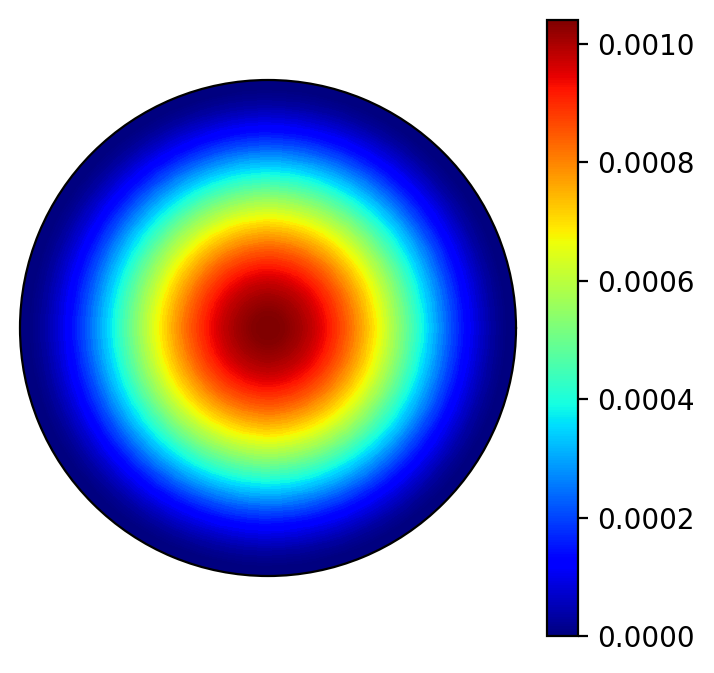

0.00104


In [ ]:
fig = plt.figure(figsize=(4, 4), dpi=200)
ax = Axes3D(fig)
ax.set_title('With masked values')
rad = np.linspace(0, a, 100)
azm = np.linspace(0, 2 * np.pi, 100)
r, th = np.meshgrid(rad, azm)
z = w(r, D)

plt.subplot(projection="polar")

cs = plt.pcolormesh(th, r, z, cmap='jet')

plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

plt.grid()
cbar = fig.colorbar(cs)

plt.show()

print(w(0,D))

#Розв'язок за допомогою PINN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1,8),
            nn.Tanh(),
            nn.Linear(8,8),
            nn.Tanh(),
            nn.Linear(8,8),
            nn.Tanh(),
            nn.Linear(8,8),
            nn.Tanh(),
            nn.Linear(8,8),
            nn.Tanh(),
            nn.Linear(8,8),
            nn.Tanh(),
            nn.Linear(8,8),
            nn.Tanh(),
            nn.Linear(8,8),
            nn.Tanh(),
            nn.Linear(8,8),

            nn.Tanh(),

            nn.Linear(8,1)
        )
        self.double()

    def forward(self, x):
        out = self.net(x)
        return out

In [ ]:
class Net:

    def __init__(self, num_iterations, num_points, q, R, D, nu):
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN().to(self.device)

        self.x_max = R


        # comp. domain
        self.h = 0.01

        self.nu = nu
        self.q = q
        self.D = D

        self.epoch = num_iterations


        x_vals = torch.linspace(0, self.x_max, num_points, requires_grad = True)
        self.X = torch.stack([x_vals.double()], dim=1)


        # print('self.X ', self.X.shape)
        # breakpoint()



        # train data
        bc1 = torch.tensor([self.x_max],  requires_grad = True).view(-1,1)

        ic  = torch.tensor([0.0],  requires_grad = True)
        ic = ic.view(-1,1)
        ic = ic.double()


        self.X_train = torch.cat([bc1, ic])

        self.bc1 = bc1
        self.ic = ic

        print('self.bc1 ', self.bc1.shape)
        # print('self.bc1 ', self.bc1)
        print('self.ic ', self.ic.shape)
        # print('self.ic ', self.ic)
        # breakpoint()

        self.y_bc1 = torch.tensor([0]).double()


        # y_ic  = ic[:,0] / (1 + torch.exp((ic[:,0]**2 - 0.25)/(4*self.nu)))

        self.y_ic  = torch.tensor([0]).double()


        self.y_train = torch.cat([self.y_bc1, self.y_bc1])
        self.y_train = self.y_train.unsqueeze(1)

        print('self.y_train ', self.y_train.shape)




        self.X = self.X.to(self.device)
        self.bc1 = self.bc1.to(self.device)
        self.ic = self.ic.to(self.device)
        self.y_train = self.y_train.to(self.device)
        # self.X.requires_grad = True

        # optimizer setting
        self.adam =  torch.optim.Adam(self.model.parameters())
        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 4000,
            max_eval = 5000,
            history_size = 50,
            tolerance_grad = 1e-10,
            tolerance_change = 1.0* np.finfo(float).eps,
            # line_search_fn ="strong_wolfe"
        )

        self.criterion = torch.nn.MSELoss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        # breakpoint()

        self.bc1 = self.bc1.double()
        ub = self.model(self.bc1)

        # breakpoint()

        ui = self.model(self.ic)

        # print('ub ', ub.shape)
        # print('ui ', ui.shape)
        # breakpoint()


        dub_dx = torch.autograd.grad(
            ub,
            self.bc1,
            grad_outputs = torch.ones_like(ub),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('dub_dx ', dub_dx.shape)
        # breakpoint()


        # dub_dxx = torch.autograd.grad(
        #     dub_dx,
        #     self.bc1,
        #     grad_outputs = torch.ones_like(dub_dx),
        #     create_graph = True,
        #     retain_graph = True
        # )[0]

        # print('dub_dxx ', dub_dxx.shape)
        # breakpoint()


        dui_dx = torch.autograd.grad(
            ui,
            self.ic,
            grad_outputs = torch.ones_like(ui),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('dui_dx ', dui_dx.shape)
        # breakpoint()

        # self.y_pred = torch.cat([ub, dub_dx, dui_dx])

        self.y_pred = torch.cat([ub, dub_dx])




        # print('self.y_pred ', self.y_pred[0].shape)


        # loss_data = self.criterion(self.y_bc1, ub) + self.criterion(self.y_bc1, (self.bc1)*dub_dxx + self.nu*dub_dx) + self.criterion(self.y_ic, dui_dx)
        loss_data = self.criterion(self.y_pred - self.y_train, torch.zeros_like(self.y_train))


        # print('loss_data ', loss_data.shape)
        # breakpoint()

        u = self.model(self.X)

        du_dx = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('du_dx ', du_dx.shape)
        # breakpoint()

        du_dxx = torch.autograd.grad(
            du_dx,
            self.X,
            grad_outputs = torch.ones_like(du_dx),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('du_dxx ', du_dxx.shape)
        # breakpoint()

        du_dxxx = torch.autograd.grad(
            du_dxx,
            self.X,
            grad_outputs = torch.ones_like(du_dxx),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('du_dxxx ', du_dxxx.shape)
        # breakpoint()

        du_dxxxx = torch.autograd.grad(
            du_dxxx,
            self.X,
            grad_outputs = torch.ones_like(du_dxxx),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('du_dxxxx ', du_dxxxx.shape)
        # breakpoint()

        residual = 1 * (self.X*self.X*self.X) * du_dxxxx + 2 * (self.X*self.X) * du_dxxx - 1 * self.X * du_dxx + 1* du_dx

        loss_pde = self.criterion(residual-torch.tensor([self.q/self.D]).double().to(self.device)*1 * (self.X*self.X*self.X), torch.zeros_like(residual))
        # loss_pde = self.criterion(residual-torch.tensor([self.q/1.0]).double()*1 * (self.X*self.X*self.X), torch.zeros_like(residual))


        loss = loss_pde + loss_data
        loss.backward()


        # print('loss ', loss.shape)
        # breakpoint()

        if self.iter % 100 == 0:
            print("iteration", self.iter, "loss", loss.item() )
            # print(self.iter, loss.item())
            # print(loss_pde.item())
            # print(loss_data.item())
        self.iter = self.iter+1

        return loss

    def train(self):
        self.model.train()
        for i in range(self.epoch):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

In [ ]:
# training
num_iterations = 20000
num_points = 200
a = 0.4
q = 0.1
G = 2.77 * 10**4
nu = 0.3
E = 2*G*(1+nu)
h = 18*10**(-3)
D = E*h**3/(12*(1-nu**2))
print(E)
print(D)



net = Net(num_iterations, num_points, q, a, D, nu)

net.train()

72020.0
0.03846342857142858
self.bc1  torch.Size([1, 1])
self.ic  torch.Size([1, 1])
self.y_train  torch.Size([2, 1])


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


iteration 100 loss 0.0003158748638300956
iteration 200 loss 8.70642110729885e-05
iteration 300 loss 6.403215441751477e-05
iteration 400 loss 5.62997506483505e-05
iteration 500 loss 5.3218519695435704e-05
iteration 600 loss 5.119994710895103e-05
iteration 700 loss 4.855264010751976e-05
iteration 800 loss 4.337610022912959e-05
iteration 900 loss 3.0886585798326366e-05
iteration 1000 loss 1.366559169434674e-05
iteration 1100 loss 7.2891242171523426e-06
iteration 1200 loss 4.642004224193087e-06
iteration 1300 loss 3.2255643191550603e-06
iteration 1400 loss 2.33665826357101e-06
iteration 1500 loss 1.7079919406893484e-06
iteration 1600 loss 1.227328214809909e-06
iteration 1700 loss 8.473391664925508e-07
iteration 1800 loss 5.506454797213926e-07
iteration 1900 loss 3.3231622635605837e-07
iteration 2000 loss 1.876132500730447e-07
iteration 2100 loss 1.1311518667610798e-07
iteration 2200 loss 6.751631782276514e-08
iteration 2300 loss 4.837655156098706e-08
iteration 2400 loss 4.018856443505709e-

In [ ]:
net.model.eval()

NN(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=8, bias=True)
    (1): Tanh()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): Tanh()
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): Tanh()
    (6): Linear(in_features=8, out_features=8, bias=True)
    (7): Tanh()
    (8): Linear(in_features=8, out_features=8, bias=True)
    (9): Tanh()
    (10): Linear(in_features=8, out_features=8, bias=True)
    (11): Tanh()
    (12): Linear(in_features=8, out_features=8, bias=True)
    (13): Tanh()
    (14): Linear(in_features=8, out_features=8, bias=True)
    (15): Tanh()
    (16): Linear(in_features=8, out_features=8, bias=True)
    (17): Tanh()
    (18): Linear(in_features=8, out_features=1, bias=True)
  )
)

##Test

In [ ]:
# h = 0.01
# k = 0.01
# a = 0.4

# x_vals = torch.linspace(0, a-0.00001, 50)


# X = torch.stack([x_vals.double()], dim=1)
# X = X.to(net.X.device)

In [ ]:
model = net.model
model.eval()
with torch.no_grad():

    x_vals = torch.linspace(0, a, 500)


    input_data = torch.stack([x_vals.double()], dim=1)
    input_data = input_data.to(net.device)
    solution = model(input_data)
    sol = torch.stack([x_vals, solution.flatten().cpu()], dim=1)

    print(sol)

tensor([[ 0.0000e+00,  1.0718e-03],
        [ 8.0160e-04,  1.0717e-03],
        [ 1.6032e-03,  1.0717e-03],
        [ 2.4048e-03,  1.0717e-03],
        [ 3.2064e-03,  1.0716e-03],
        [ 4.0080e-03,  1.0715e-03],
        [ 4.8096e-03,  1.0714e-03],
        [ 5.6112e-03,  1.0712e-03],
        [ 6.4128e-03,  1.0711e-03],
        [ 7.2144e-03,  1.0709e-03],
        [ 8.0160e-03,  1.0708e-03],
        [ 8.8176e-03,  1.0706e-03],
        [ 9.6192e-03,  1.0703e-03],
        [ 1.0421e-02,  1.0701e-03],
        [ 1.1222e-02,  1.0699e-03],
        [ 1.2024e-02,  1.0696e-03],
        [ 1.2826e-02,  1.0693e-03],
        [ 1.3627e-02,  1.0690e-03],
        [ 1.4429e-02,  1.0687e-03],
        [ 1.5230e-02,  1.0683e-03],
        [ 1.6032e-02,  1.0680e-03],
        [ 1.6834e-02,  1.0676e-03],
        [ 1.7635e-02,  1.0672e-03],
        [ 1.8437e-02,  1.0668e-03],
        [ 1.9238e-02,  1.0664e-03],
        [ 2.0040e-02,  1.0659e-03],
        [ 2.0842e-02,  1.0655e-03],
        [ 2.1643e-02,  1.065

In [ ]:
sol_np = sol.numpy()
np.shape(sol_np)
points = sol_np[:, 0]
points

array([0.        , 0.0008016 , 0.00160321, 0.00240481, 0.00320641,
       0.00400802, 0.00480962, 0.00561122, 0.00641283, 0.00721443,
       0.00801603, 0.00881764, 0.00961924, 0.01042084, 0.01122244,
       0.01202405, 0.01282565, 0.01362725, 0.01442886, 0.01523046,
       0.01603206, 0.01683367, 0.01763527, 0.01843687, 0.01923848,
       0.02004008, 0.02084168, 0.02164329, 0.02244489, 0.02324649,
       0.0240481 , 0.0248497 , 0.0256513 , 0.0264529 , 0.02725451,
       0.02805611, 0.02885772, 0.02965932, 0.03046092, 0.03126252,
       0.03206413, 0.03286573, 0.03366733, 0.03446894, 0.03527054,
       0.03607214, 0.03687375, 0.03767535, 0.03847695, 0.03927856,
       0.04008016, 0.04088176, 0.04168336, 0.04248497, 0.04328657,
       0.04408818, 0.04488978, 0.04569138, 0.04649299, 0.04729459,
       0.04809619, 0.0488978 , 0.0496994 , 0.050501  , 0.0513026 ,
       0.05210421, 0.05290581, 0.05370741, 0.05450902, 0.05531062,
       0.05611222, 0.05691383, 0.05771543, 0.05851703, 0.05931

In [ ]:
pred_y = []
true_y = []
pred_y = sol_np[:, 1]
for x in points:
    true_y.append(w(x, D))

print(true_y)

[0.00104, 0.00104, 0.00104, 0.00104, 0.00104, 0.00104, 0.00104, 0.00104, 0.001039, 0.001039, 0.001039, 0.001039, 0.001039, 0.001039, 0.001038, 0.001038, 0.001038, 0.001038, 0.001037, 0.001037, 0.001037, 0.001036, 0.001036, 0.001036, 0.001035, 0.001035, 0.001034, 0.001034, 0.001033, 0.001033, 0.001032, 0.001032, 0.001031, 0.001031, 0.00103, 0.00103, 0.001029, 0.001029, 0.001028, 0.001027, 0.001027, 0.001026, 0.001025, 0.001025, 0.001024, 0.001023, 0.001022, 0.001022, 0.001021, 0.00102, 0.001019, 0.001018, 0.001017, 0.001017, 0.001016, 0.001015, 0.001014, 0.001013, 0.001012, 0.001011, 0.00101, 0.001009, 0.001008, 0.001007, 0.001006, 0.001005, 0.001004, 0.001003, 0.001002, 0.001001, 0.000999, 0.000998, 0.000997, 0.000996, 0.000995, 0.000993, 0.000992, 0.000991, 0.00099, 0.000988, 0.000987, 0.000986, 0.000985, 0.000983, 0.000982, 0.00098, 0.000979, 0.000978, 0.000976, 0.000975, 0.000973, 0.000972, 0.00097, 0.000969, 0.000967, 0.000966, 0.000964, 0.000963, 0.000961, 0.00096, 0.000958, 0.000

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot

def plot_feature(true_y, pred_y, points):

    fig_prices = go.Figure()
    fig_prices.add_trace(go.Scatter(x=points, y=true_y,
                        # fill= 'tonexty',
                        mode='lines',
                        # line_color='indigo',
                        name="Точний розв'язок"))
    fig_prices.add_trace(go.Scatter(
                        x=points,
                        y=pred_y,
                        # fill='tonexty', # fill area between trace0 and trace1
                        mode='lines',
                        # line_color='red',
                        name="Наближений розв'язок"))


    fig_prices.update_layout(yaxis_title="Значення функції")
    fig_prices.update_layout(
    xaxis=dict(
        title='Точки колокації',
        title_font=dict(size=20),  # Збільшення розміру шрифту підпису осі X
        tickfont=dict(size=16),    # Збільшення розміру шрифту тікерів
    ),
    yaxis=dict(
        title='Значення функції',
        title_font=dict(size=20),  # Збільшення розміру шрифту підпису осі Y
        tickfont=dict(size=16),    # Збільшення розміру шрифту тікерів
    ),
    legend=dict(
        font=dict(size=18)          # Збільшення розміру шрифту легенди
    )
)
    fig_prices.show()

    return 0

In [ ]:
plot_feature(true_y, pred_y, points)

0

In [ ]:
import pandas as pd
import numpy as np

# Об'єднання масивів в DataFrame та назви стовпців
df = pd.DataFrame({'True': true_y, 'Pred': np.round(pred_y, 6)})

# Вивід DataFrame
print(df)

        True      Pred
0    0.00104  0.001072
1    0.00104  0.001072
2    0.00104  0.001072
3    0.00104  0.001072
4    0.00104  0.001072
..       ...       ...
495  0.00000  0.000000
496  0.00000  0.000000
497  0.00000  0.000000
498  0.00000  0.000000
499  0.00000 -0.000000

[500 rows x 2 columns]


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# mean_absolute_percentage_error([df['True'][0]], [df['Pred'][0]])

np.abs(df['True'][0] - df['Pred'][0])/df['True'][0]*100

3.0769230769230895

#Обернена задача

In [ ]:
class Net_inv:

    def __init__(self, num_iterations, num_points, q, R, nu, uf):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.qdivD_true = 2.59987
        # self.D_true = 0.03846
        lambda_value = 3.0

        print("the real value =",self.qdivD_true, "     Our I-PINNs value=", lambda_value)
        self.lambda_value = torch.tensor([lambda_value], requires_grad=True).double().to(device)

        self.lambda_value = nn.Parameter(self.lambda_value)

        self.model = NN().to(device)

        self.model.register_parameter('lambda_value', self.lambda_value)

        self.x_max = R


        # comp. domain
        self.h = 0.01

        self.nu =torch.tensor([nu], requires_grad=True).double()
        self.q = torch.tensor([q], requires_grad=True).double()
        # self.D = D

        self.epoch = num_iterations
        self.lambda_hist = []


        x_vals = torch.linspace(0, self.x_max, num_points, requires_grad = True)
        self.X = torch.stack([x_vals.double()], dim=1)


        # print('self.X ', self.X.shape)
        # breakpoint()



        # train data
        bc1 = torch.tensor([self.x_max],  requires_grad = True).view(-1,1)

        ic  = torch.tensor([0.0],  requires_grad = True)
        ic = ic.view(-1,1)
        ic = ic.double()


        self.X_train = torch.cat([bc1, ic])

        self.bc1 = bc1
        self.ic = ic

        # print('self.bc1 ', self.bc1.shape)
        # print('self.bc1 ', self.bc1)
        # print('self.ic ', self.ic.shape)
        # print('self.ic ', self.ic)
        # breakpoint()

        self.y_bc1 = torch.tensor([0]).double()


        # y_ic  = ic[:,0] / (1 + torch.exp((ic[:,0]**2 - 0.25)/(4*self.nu)))

        self.y_ic  = torch.tensor([0]).double()


        self.y_train = torch.tensor(uf)

        self.y_train = self.y_train.view(-1)
        self.y_train = self.y_train.unsqueeze(1)

        print('self.y_train ', self.y_train.shape)

        self.y_train_b = torch.cat([self.y_train[-1], self.y_train[-1], self.y_train[-1]])

        # self.y_train_b = torch.cat([self.y_ic, self.y_ic, self.y_ic])


        self.X = self.X.to(device)
        self.bc1 = self.bc1.to(device)
        self.ic = self.ic.to(device)
        self.y_train = self.y_train.to(device)
        # self.X.requires_grad = True

        # optimizer setting
        self.adam =  torch.optim.Adam(self.model.parameters())
        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 2000,
            max_eval = 2000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )

        self.criterion = torch.nn.MSELoss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        # breakpoint()

        self.bc1 = self.bc1.double()
        ub = self.model(self.bc1)

        # # breakpoint()

        ui = self.model(self.ic)

        # # print('ub ', ub.shape)
        # # print('ui ', ui.shape)
        # # breakpoint()


        dub_dx = torch.autograd.grad(
            ub,
            self.bc1,
            grad_outputs = torch.ones_like(ub),
            create_graph = True,
            retain_graph = True
        )[0]

        # # print('dub_dx ', dub_dx.shape)
        # # breakpoint()


        # dub_dxx = torch.autograd.grad(
        #     dub_dx,
        #     self.bc1,
        #     grad_outputs = torch.ones_like(dub_dx),
        #     create_graph = True,
        #     retain_graph = True
        # )[0]

        # # print('dub_dxx ', dub_dxx.shape)
        # # breakpoint()


        dui_dx = torch.autograd.grad(
            ui,
            self.ic,
            grad_outputs = torch.ones_like(ui),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('dui_dx ', dui_dx.shape)
        # breakpoint()

        # self.y_pred = torch.cat([ub, 1*((self.bc1)*dub_dxx + self.nu*dub_dx), dui_dx])
        # print('self.y_pred ', self.y_pred.shape)

        # self.y_pred = self.y_pred.unsqueeze(1)


        self.y_pred_b = torch.cat([ub, dub_dx, dui_dx])

        self.y_pred_b = self.y_pred_b.view(-1)

        loss_data_b = self.criterion(self.y_pred_b, self.y_train_b)

        self.y_pred =  self.model(self.X)

        # loss_data = self.criterion(self.y_bc1, ub) + self.criterion(self.y_bc1, (self.bc1)*dub_dxx + self.nu*dub_dx) + self.criterion(self.y_ic, dui_dx)
        loss_data = self.criterion(self.y_pred - self.y_train, torch.zeros_like(self.y_train))


        # print('loss_data ', loss_data.shape)
        # breakpoint()

        u = self.model(self.X)

        du_dx = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('du_dx ', du_dx.shape)
        # breakpoint()

        du_dxx = torch.autograd.grad(
            du_dx,
            self.X,
            grad_outputs = torch.ones_like(du_dx),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('du_dxx ', du_dxx.shape)
        # breakpoint()

        du_dxxx = torch.autograd.grad(
            du_dxx,
            self.X,
            grad_outputs = torch.ones_like(du_dxx),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('du_dxxx ', du_dxxx.shape)
        # breakpoint()

        du_dxxxx = torch.autograd.grad(
            du_dxxx,
            self.X,
            grad_outputs = torch.ones_like(du_dxxx),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('du_dxxxx ', du_dxxxx.shape)
        # breakpoint()

        residual = 1 * (self.X*self.X*self.X) * du_dxxxx + 2 * (self.X*self.X) * du_dxxx - 1 * self.X * du_dxx + 1* du_dx

        # loss_pde = self.criterion(residual-torch.tensor([self.q/self.lambda_value]).double()*1 * (self.X*self.X*self.X), torch.zeros_like(residual))

        # lambda_pde = self.lambda_value

        # loss_pde = self.criterion(residual - torch.tensor([lambda_pde]).double()*1 * (self.X*self.X*self.X), torch.zeros_like(residual))

        # loss_pde = self.criterion(residual - self.lambda_value*1 * (self.X*self.X*self.X), torch.zeros_like(residual))

        loss_pde = self.criterion(residual, self.lambda_value*1 * (self.X*self.X*self.X))

        loss = loss_pde + loss_data + loss_data_b
        # loss = loss_pde + loss_data
        loss.backward()


        # print('loss ', loss.shape)
        # breakpoint()

        self.lambda_hist.append(self.lambda_value.item())

        if self.iter % 100 == 0:
            # print("itration", self.iter, "loss", loss.item() )
            print("iteration number =",self.iter, " loss =", loss.item(), " loss data =", loss_data.item(),
                  " loss pde =", loss_pde.item(), "real D=", self.qdivD_true," IPINN lambda=", self.lambda_value.item())
            # print(self.iter, loss.item())
            # print(loss_pde.item())
            # print(loss_data.item())
        self.iter = self.iter+1

        return loss

    def train(self):
        self.model.train()
        for i in range(self.epoch):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

##Test

In [ ]:
solution.shape

torch.Size([500, 1])

In [ ]:
net_inv = Net_inv(10000, 500, q, a, nu, solution)
net_inv.train()
net_inv.model.eval()

the real value = 2.59987      Our I-PINNs value= 3.0
self.y_train  torch.Size([500, 1])


<ipython-input-106-8d322f0ca4e2>:69: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



iteration number = 100  loss = 0.003242209017333208  loss data = 1.3242629204683118e-05  loss pde = 0.0027334857640155838 real D= 2.59987  IPINN lambda= 2.911170386703752
iteration number = 200  loss = 0.0006171633870938067  loss data = 1.2598573605296718e-05  loss pde = 0.00020683932664513399 real D= 2.59987  IPINN lambda= 2.847685440975044
iteration number = 300  loss = 5.678604199502068e-05  loss data = 2.1059422161263107e-06  loss pde = 4.380096117149072e-05 real D= 2.59987  IPINN lambda= 2.83905923410068
iteration number = 400  loss = 4.96269322084644e-05  loss data = 1.1828938298557202e-06  loss pde = 3.789887823726475e-05 real D= 2.59987  IPINN lambda= 2.836520035145062
iteration number = 500  loss = 4.3257101642129456e-05  loss data = 1.2287898987678851e-06  loss pde = 3.439216671366995e-05 real D= 2.59987  IPINN lambda= 2.833885808088891
iteration number = 600  loss = 3.630883300826535e-05  loss data = 7.496500812120311e-07  loss pde = 2.9126268406800683e-05 real D= 2.59987  I

NN(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=8, bias=True)
    (1): Tanh()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): Tanh()
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): Tanh()
    (6): Linear(in_features=8, out_features=8, bias=True)
    (7): Tanh()
    (8): Linear(in_features=8, out_features=8, bias=True)
    (9): Tanh()
    (10): Linear(in_features=8, out_features=8, bias=True)
    (11): Tanh()
    (12): Linear(in_features=8, out_features=8, bias=True)
    (13): Tanh()
    (14): Linear(in_features=8, out_features=8, bias=True)
    (15): Tanh()
    (16): Linear(in_features=8, out_features=8, bias=True)
    (17): Tanh()
    (18): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [ ]:
with torch.no_grad():

    x_vals_inv = torch.linspace(0, a, 200)


    input_data_inv = torch.stack([x_vals_inv.double()], dim=1)
    input_data_inv = input_data_inv.to(net.device)
    solution_inv = net_inv.model(input_data_inv)
    sol_inv = torch.stack([x_vals_inv, solution_inv.flatten().cpu()], dim=1)

    print(sol)

tensor([[ 0.0000e+00,  1.0718e-03],
        [ 8.0160e-04,  1.0717e-03],
        [ 1.6032e-03,  1.0717e-03],
        [ 2.4048e-03,  1.0717e-03],
        [ 3.2064e-03,  1.0716e-03],
        [ 4.0080e-03,  1.0715e-03],
        [ 4.8096e-03,  1.0714e-03],
        [ 5.6112e-03,  1.0712e-03],
        [ 6.4128e-03,  1.0711e-03],
        [ 7.2144e-03,  1.0709e-03],
        [ 8.0160e-03,  1.0708e-03],
        [ 8.8176e-03,  1.0706e-03],
        [ 9.6192e-03,  1.0703e-03],
        [ 1.0421e-02,  1.0701e-03],
        [ 1.1222e-02,  1.0699e-03],
        [ 1.2024e-02,  1.0696e-03],
        [ 1.2826e-02,  1.0693e-03],
        [ 1.3627e-02,  1.0690e-03],
        [ 1.4429e-02,  1.0687e-03],
        [ 1.5230e-02,  1.0683e-03],
        [ 1.6032e-02,  1.0680e-03],
        [ 1.6834e-02,  1.0676e-03],
        [ 1.7635e-02,  1.0672e-03],
        [ 1.8437e-02,  1.0668e-03],
        [ 1.9238e-02,  1.0664e-03],
        [ 2.0040e-02,  1.0659e-03],
        [ 2.0842e-02,  1.0655e-03],
        [ 2.1643e-02,  1.065

In [ ]:
sol_np_inv = sol_inv.numpy()
np.shape(sol_np_inv)
points_inv = sol_np_inv[:, 0]
points_inv

array([0.        , 0.00201005, 0.0040201 , 0.00603015, 0.0080402 ,
       0.01005025, 0.0120603 , 0.01407035, 0.0160804 , 0.01809045,
       0.0201005 , 0.02211055, 0.0241206 , 0.02613065, 0.0281407 ,
       0.03015075, 0.0321608 , 0.03417085, 0.03618091, 0.03819095,
       0.040201  , 0.04221106, 0.0442211 , 0.04623115, 0.04824121,
       0.05025126, 0.05226131, 0.05427136, 0.05628141, 0.05829146,
       0.06030151, 0.06231156, 0.06432161, 0.06633165, 0.06834171,
       0.07035176, 0.07236181, 0.07437186, 0.07638191, 0.07839196,
       0.08040201, 0.08241206, 0.08442211, 0.08643216, 0.08844221,
       0.09045226, 0.09246231, 0.09447236, 0.09648241, 0.09849246,
       0.10050251, 0.10251256, 0.10452262, 0.10653266, 0.10854271,
       0.11055277, 0.11256281, 0.11457286, 0.11658292, 0.11859296,
       0.12060301, 0.12261306, 0.12462311, 0.12663317, 0.12864321,
       0.13065326, 0.13266331, 0.13467337, 0.13668342, 0.13869347,
       0.14070351, 0.14271356, 0.14472362, 0.14673367, 0.14874

In [ ]:
pred_y_inv = []
true_y_inv = []
pred_y_inv = sol_np_inv[:, 1]
for x in points_inv:
    true_y_inv.append(w(x, D))

print(true_y_inv)

[0.00104, 0.00104, 0.00104, 0.001039, 0.001039, 0.001039, 0.001038, 0.001037, 0.001037, 0.001036, 0.001035, 0.001034, 0.001032, 0.001031, 0.00103, 0.001028, 0.001027, 0.001025, 0.001023, 0.001021, 0.001019, 0.001017, 0.001015, 0.001012, 0.00101, 0.001007, 0.001005, 0.001002, 0.000999, 0.000996, 0.000993, 0.00099, 0.000987, 0.000984, 0.00098, 0.000977, 0.000973, 0.000969, 0.000965, 0.000962, 0.000958, 0.000954, 0.000949, 0.000945, 0.000941, 0.000936, 0.000932, 0.000927, 0.000922, 0.000918, 0.000913, 0.000908, 0.000903, 0.000898, 0.000892, 0.000887, 0.000882, 0.000876, 0.000871, 0.000865, 0.000859, 0.000854, 0.000848, 0.000842, 0.000836, 0.00083, 0.000824, 0.000818, 0.000811, 0.000805, 0.000799, 0.000792, 0.000785, 0.000779, 0.000772, 0.000765, 0.000759, 0.000752, 0.000745, 0.000738, 0.000731, 0.000724, 0.000717, 0.00071, 0.000702, 0.000695, 0.000688, 0.00068, 0.000673, 0.000666, 0.000658, 0.00065, 0.000643, 0.000635, 0.000628, 0.00062, 0.000612, 0.000604, 0.000597, 0.000589, 0.000581, 0

In [ ]:
plot_feature(true_y_inv, pred_y_inv, points_inv)

0

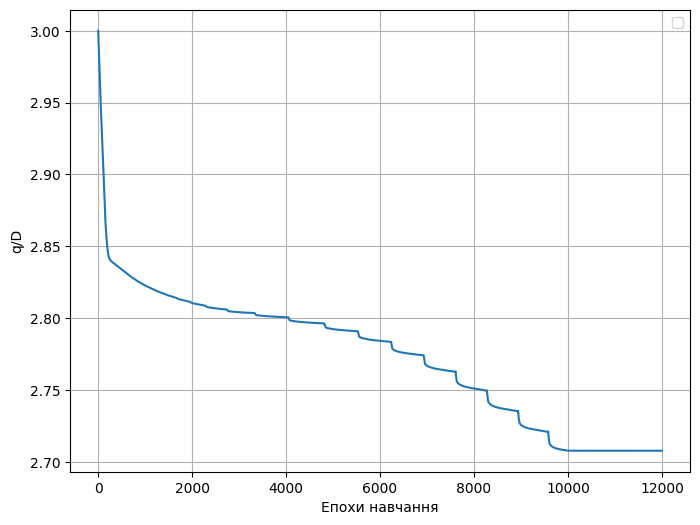

In [ ]:
# Побудова графіку
plt.figure(figsize=(8, 6))    # Розміри графіку (ширина, висота) в дюймах

plt.plot(net_inv.lambda_hist)

# Додавання заголовку, підписів вісей та легенди
# plt.title('Графік декількох кривих')
plt.xlabel('Eпохи навчання')
plt.ylabel('q/D')
plt.legend()   # Виведення легенди з назвами кривих

# Показати графік
plt.grid(True)   # Включити сітку
plt.show()


In [ ]:
import plotly.express as px
import pandas as pd

# Дані
epochs = list(range(1, len(net_inv.lambda_hist) + 1))  # Список епох навчання
E_values = net_inv.lambda_hist

# Створення DataFrame для зручності
data = pd.DataFrame({'Епохи': epochs, 'Значення q/D': E_values})

# Побудова графіку за допомогою Plotly
fig = px.line(data, x='Епохи', y='Значення q/D', title='Зміна значення q/D під час навчання моделі', markers=True)
fig.update_layout(
    # title='Зміна значення E під час навчання моделі'
    title={
        'text': 'Зміна значення q/D під час навчання моделі',
        'y':0.85,  # Вертикальне позиціонування заголовка
        'x':0.5,  # Горизонтальне вирівнювання по центру
        'xanchor': 'center',  # Центрування по осі x
        'yanchor': 'top',  # Якір для осі y
        'font': {'size':24, 'family':'Arial', 'color':'black'}
    },
    xaxis_title='Епохи навчання',
    yaxis_title='Значення параметра q/D',
    xaxis=dict(title_font=dict(size=24, family='Arial', color='black')),
    yaxis=dict(title_font=dict(size=24, family='Arial', color='black')),
    font=dict(size=22, family='Arial'),
    template='plotly_white'
)
fig.update_xaxes(tickformat="t")

# Відображення графіку
fig.show()


In [ ]:
net_inv.qdivD_true

2.59987

In [ ]:
net_inv.lambda_hist[-1]

2.707795479487373

In [ ]:
np.abs(net_inv.qdivD_true - net_inv.lambda_hist[-1])/net_inv.qdivD_true*100

4.15118753966055